In [250]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

!pip install tensorflow-gpu
!pip install nltk
!pip install keras
!pip install wordcloud

In [251]:
import numpy as np
import nltk
import joblib
import re
import pydot
from wordcloud import WordCloud, ImageColorGenerator
#import tensorflow as tf
#from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import pandas as pd
import seaborn as sns
#import plotly.graph_objects as go
#import chart_studio.plotly as py
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

#import numpy as np 
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
#from keras.callbacks import EarlyStopping
#from keras.layers import Dropout
#import re
#from nltk.corpus import stopwords
#from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [325]:
df = pd.read_csv('coded_sub_section.csv',header=0)


In [326]:
df.head()

,Textfile,Determination_Year,Sub_Header,Sub_Section,Cond_Category,EScore
0,/home/admin/dockers/masters/data/pdfminer/search/MP08_0256-Mod-2.txt,2012.0,Pollution of Waters,Except as may be expressly provided by a OEH Environment Protection Licence the Proponent shall comply with section 120 of the Protection of the Environment Operations Act 1997 during the carrying out of the Project.,1,0.8550
1,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,The Proponent shall carry out the proposed diversions of Bettys Creek and Main Creek in the underground project area to the satisfaction of the Director-General.,1,0.4275
2,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,Within 6 months of completing the construction of the diversions the Proponent shall submit an as-executed report certified by a practising engineer to the Director-General and NOW.,1,0.6650
3,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,Except as may be expressly provided for by an EPL or in accordance with section 120 of the Protection of the Environment Operations Act 1997 the Proponent shall not discharge any mine water from the site.,1,0.8550
4,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,However water may be transferred between the site and the adjoining Donaldson Coal Mine and/or Abel Coal Mine in accordance with any approved Water Management Plan (see below).,1,0.5400


In [327]:
df.shape

(1033, 6)

In [328]:
df.Cond_Category.value_counts()

3    401
4    263
1    197
2    172
Name: Cond_Category, dtype: int64

<AxesSubplot:title={'center':'Condition Count Chart by Category'}, xlabel='Category', ylabel='No of Conditions'>

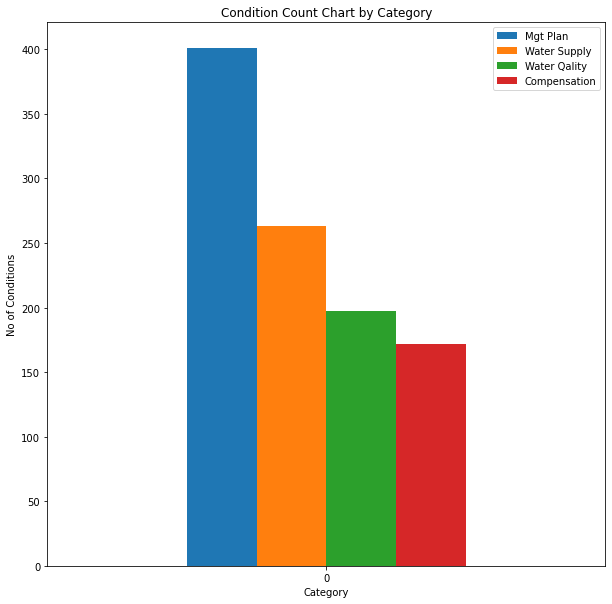

In [329]:
fields = [401,263,197,172]
data = []
data.append(fields)
cols = ['Mgt Plan','Water Supply','Water Qality','Compensation']
df_cat = pd.DataFrame(data=data,columns=cols)
df_cat.plot.bar(rot=0,title='Condition Count Chart by Category',xlabel='Category',ylabel='No of Conditions',figsize=(10,10))
#df['Stars'].value_counts().plot.bar(rot=0,title='Condition Star Count Chart',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))

In [330]:
df.Determination_Year.value_counts()

2015.0    144
2019.0    131
2016.0    125
2012.0    114
2014.0     99
2017.0     94
2018.0     91
2020.0     88
2013.0     54
2021.0     20
Name: Determination_Year, dtype: int64

In [331]:
df = df.drop(['Textfile','Sub_Header','Cond_Category','Determination_Year'],axis=1)

In [332]:
df['Stars'] = 0
df.head()

,Sub_Section,EScore,Stars
0,Except as may be expressly provided by a OEH Environment Protection Licence the Proponent shall comply with section 120 of the Protection of the Environment Operations Act 1997 during the carrying out of the Project.,0.8550,0
1,The Proponent shall carry out the proposed diversions of Bettys Creek and Main Creek in the underground project area to the satisfaction of the Director-General.,0.4275,0
2,Within 6 months of completing the construction of the diversions the Proponent shall submit an as-executed report certified by a practising engineer to the Director-General and NOW.,0.6650,0
3,Except as may be expressly provided for by an EPL or in accordance with section 120 of the Protection of the Environment Operations Act 1997 the Proponent shall not discharge any mine water from the site.,0.8550,0
4,However water may be transferred between the site and the adjoining Donaldson Coal Mine and/or Abel Coal Mine in accordance with any approved Water Management Plan (see below).,0.5400,0


In [333]:
for i in range(len(df)):
    if df.iloc[i,1] < .2:
        df.iloc[i,2] = 1
    elif df.iloc[i,1] < .4:
        df.iloc[i,2] = 2
    elif df.iloc[i,1] < .6:
        df.iloc[i,2] = 3
    elif df.iloc[i,1] < .8:
        df.iloc[i,2] = 4
    elif df.iloc[i,1] > .8:
        df.iloc[i,2] = 5  
        
df = df.drop(['EScore'],axis=1)

In [334]:
print(STOPWORDS)

{'because', 's', "needn't", 'once', 'down', 've', 'up', "haven't", 'these', 'did', 'environment', 'very', "didn't", 'below', 'y', 'them', "doesn't", 'been', 'under', "it's", 'him', 'won', "you're", 'at', 'further', 'she', 'me', 'we', 'why', 'such', 'into', 'a', 'mustn', 'they', 'wouldn', 'an', 'ma', 'our', 'haven', 'ours', 'against', 'it', 'no', 'more', 'doesn', 'you', 'then', 'same', "shouldn't", 'himself', 'yours', 'most', 'when', 'but', 'few', 'couldn', 'shan', 'with', "isn't", 'that', 'i', 'have', 'project', 'this', 'herself', 'above', 'on', 'don', "should've", "hasn't", "won't", 'is', 'for', 'in', 'during', 'own', "hadn't", "wasn't", 'applicant', 'creek', 'am', 'ain', 'are', 'any', 'themselves', 'itself', 'water', 'was', 'which', 'proponent', 'yourself', 'and', 'the', 'can', 'after', 'some', 'isn', "she's", 'until', 'didn', 'yourselves', "that'll", 'o', "mightn't", 'about', 'will', "aren't", 'myself', 'weren', 'my', 'how', 'all', 'm', 'theirs', 'whom', 'aren', 'hasn', 'mightn', 't

# Text Processing 

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove stop words.
- Remove digits in text.
- Remove single letters


In [335]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SINGLE_LETTERS_RE = re.compile('\s+[a-zA-Z]\s+')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove('should')
STOPWORDS.add('applicant')
STOPWORDS.add('proponent')
STOPWORDS.add('groundwater')
STOPWORDS.add('water')
STOPWORDS.add('environment')
STOPWORDS.add('act')
STOPWORDS.add('project')
STOPWORDS.add('creek')


def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = SINGLE_LETTERS_RE.sub('', text) # remove single letters
#    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Sub_Section'] = df['Sub_Section'].apply(clean_text)
df['Sub_Section'] = df['Sub_Section'].str.replace('\d+', '')

In [336]:
print(df['Sub_Section'][600])

plan must consistent requirements managing urban stormwater soils construction manual landcom  latest version ii identify activities could cause soil erosion generate sediment iii describe measures minimise soil erosion potential transport sediment downstream waters iv describe location function capacity erosion sediment control structures v describe measures would implemented monitor maintain structures time


In [337]:
df['Sub_Section'].describe()

count                                                                                                 1033
unique                                                                                                 436
top       compensatory supply measures must provide alternative longterm supply equivalent loss attributed
freq                                                                                                    45
Name: Sub_Section, dtype: object

In [338]:

#count no of words in the sub_section string and in the total in the all the conditions
def word_count(text):

    return(len(text.strip().split(" ")))


tot_word = 0
word_no = []
for i in range(len(df)):
    
    word_no.append(word_count(str(df.iloc[i,0])))
    tot_word = tot_word + (word_count(str(df.iloc[i,0])))

df_word = pd.DataFrame(data=word_no,index=None)
                                     
print(f"Total words: {tot_word}")
df_word.describe()



Total words: 19255


,0
count,1033.000000
mean,18.639884
std,18.078587
min,1.000000
25%,9.000000
50%,13.000000
75%,20.000000
max,283.000000


<AxesSubplot:title={'center':'Condition Word Count Chart'}, xlabel='Word Count', ylabel='No of Conditions'>

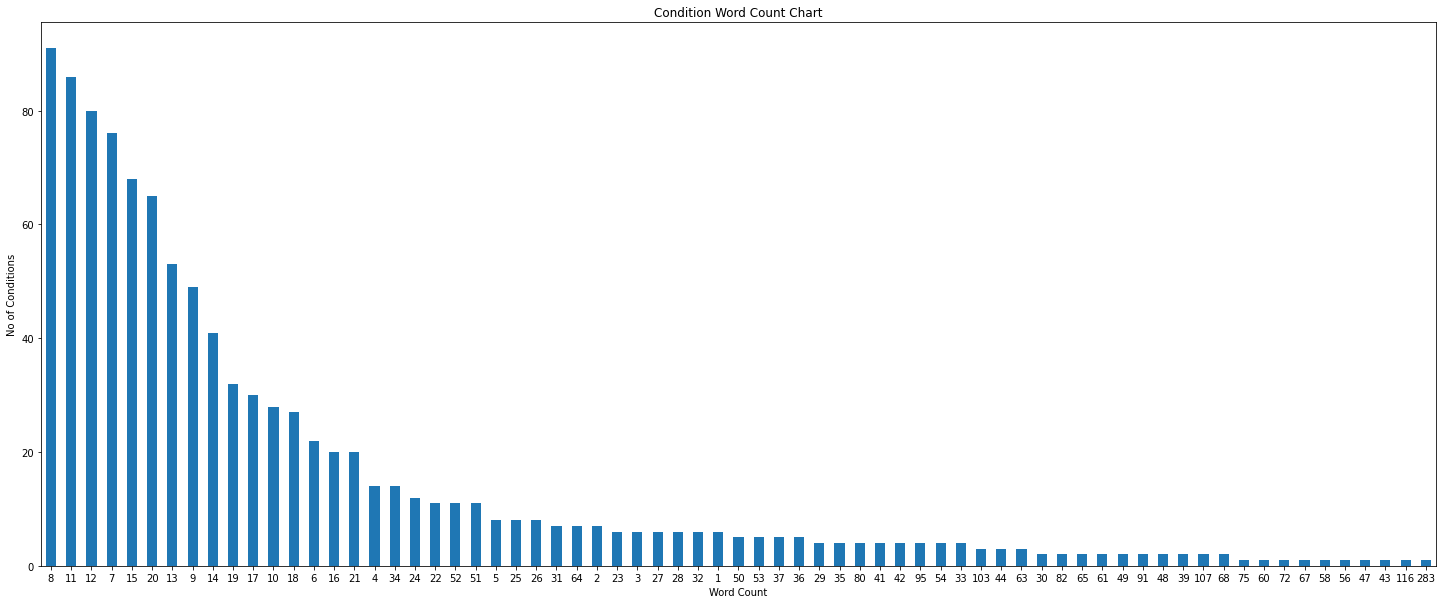

In [339]:
df_word[0].value_counts().plot.bar(rot=0,title='Condition Word Count Chart',xlabel='Word Count',ylabel='No of Conditions',figsize=(25,10))

<AxesSubplot:title={'center':'Condition Star Count Chart'}, xlabel='Stars', ylabel='No of Conditions'>

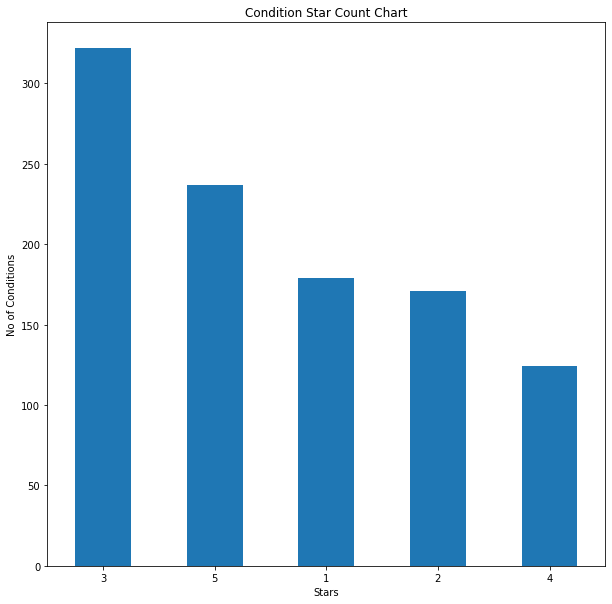

In [341]:
df['Stars'].value_counts().plot.bar(rot=0,title='Condition Star Count Chart',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))
#df.Stars.value_counts().plot.hist(bins=5,title='Condition Star Count Chart',xlabel='Stars',ylabel='No of Conditions',figsize=(10,10))


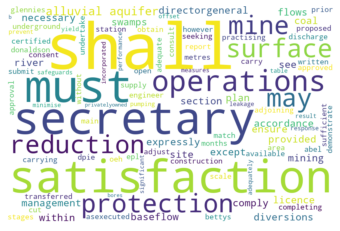

In [267]:
wordcloud = WordCloud(max_words=100, stopwords=STOPWORDS, background_color="white",width=1200,height=800).generate(str(df['Sub_Section']))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear', )
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("wordcloud.png")

# Tokenising

- Vectorize text into either a sequence of integers or into a vector.
- Limit the data set to the top 125,0000 words.
- Set the max number of words for each sub_section at 500.
- Truncate and pad the subsections with zeros


In [268]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sub_Section'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['Sub_Section'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(df['Stars']).values
print('Shape of label tensor:', Y.shape)

Found 1006 unique tokens.
Shape of data tensor: (1033, 100)
Shape of label tensor: (1033, 5)


In [269]:
print((df['Stars']).values)

[5 3 4 ... 3 3 2]


In [270]:
df['Stars'].describe()

count    1033.000000
mean        3.066796
std         1.376150
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Stars, dtype: float64

In [271]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(929, 100) (929, 5)
(104, 100) (104, 5)


In [272]:
#sns.lineplot(x=train.index, y="Stars", data=train);
#sns.lineplot(x=test.index, y="Stars", data=test);

In [273]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          300000    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 380,905
Trainable params: 380,905
Non-trainable params: 0
_________________________________________________________________
None


In [275]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
14/14 [==============================] - 4s 141ms/step - loss: 1.5855 - accuracy: 0.2936 - val_loss: 1.3499 - val_accuracy: 0.4194
Epoch 2/20
14/14 [==============================] - 2s 121ms/step - loss: 1.3984 - accuracy: 0.4063 - val_loss: 1.1192 - val_accuracy: 0.6774
Epoch 3/20
14/14 [==============================] - 2s 128ms/step - loss: 1.1529 - accuracy: 0.6591 - val_loss: 0.8055 - val_accuracy: 0.7634
Epoch 4/20
14/14 [==============================] - 2s 125ms/step - loss: 0.8308 - accuracy: 0.7711 - val_loss: 0.6209 - val_accuracy: 0.8925
Epoch 5/20
14/14 [==============================] - 2s 125ms/step - loss: 0.6112 - accuracy: 0.8371 - val_loss: 0.4890 - val_accuracy: 0.8710
Epoch 6/20
14/14 [==============================] - 2s 120ms/step - loss: 0.4430 - accuracy: 0.8623 - val_loss: 0.3661 - val_accuracy: 0.9140
Epoch 7/20
14/14 [==============================] - 2s 126ms/step - loss: 0.3028 - accuracy: 0.9224 - val_loss: 0.3653 - val_accuracy: 0.8817
Epoch 

In [277]:
# save the model to disk
model.save('jup_enforceability_model.h5')
joblib.dump(tokenizer, "jup_data_tokenizer.joblib")

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4/4 [==============================] - 0s 17ms/step - loss: 0.1783 - accuracy: 0.9615
Test set
  Loss: 0.178
  Accuracy: 0.962


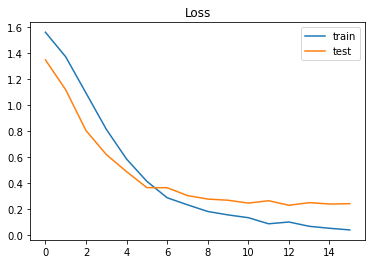

In [282]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [279]:
print(history.history)

{'loss': [1.5626252889633179, 1.3734811544418335, 1.094618797302246, 0.8153756856918335, 0.5859171748161316, 0.41452109813690186, 0.2878996431827545, 0.23376289010047913, 0.18235884606838226, 0.15589749813079834, 0.13443848490715027, 0.08749358355998993, 0.10127498209476471, 0.0682578757405281, 0.05296233668923378, 0.04032256454229355], 'accuracy': [0.32057416439056396, 0.47248804569244385, 0.690191388130188, 0.7787081599235535, 0.8265550136566162, 0.8636363744735718, 0.9282296895980835, 0.9330143332481384, 0.9449760913848877, 0.9521530866622925, 0.9557416439056396, 0.9784688949584961, 0.9665071964263916, 0.9868420958518982, 0.9868420958518982, 0.9904305934906006], 'val_loss': [1.3499354124069214, 1.1192455291748047, 0.8054545521736145, 0.6208520531654358, 0.48897454142570496, 0.3661327660083771, 0.3652632534503937, 0.3047833740711212, 0.2778633236885071, 0.2688979208469391, 0.24701909720897675, 0.265017032623291, 0.23024651408195496, 0.2501966953277588, 0.23980441689491272, 0.24232576

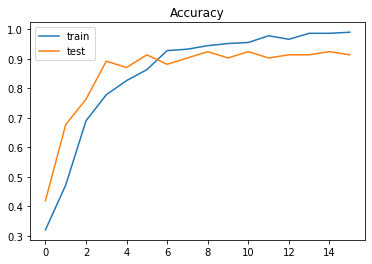

In [280]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [281]:
tokenizer = joblib.load("jup_data_tokenizer.joblib")

new_sub_header = ['The Proponent shall ensure that all surface water discharges from the site comply with the discharge limits (both volume and quality) set for the project in any EPL.']

df_new = pd.DataFrame(new_sub_header)
df_new[0] = df_new[0].apply(clean_text)
df_new[0] = df_new[0].str.replace('\d+', '')

pd.set_option('display.max_colwidth', None)
print(str(df_new[0]))


seq = tokenizer.texts_to_sequences(df_new[0].values)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', padded.shape)
print(padded)

pred = model.predict(padded)
labels = ['1', '2', '3', '4', '5']
print(pred, labels[np.argmax(pred)])
#print(pred,[np.argmax(pred)])                 

0    shall ensure surface discharges site comply discharge limits volume quality set epl
Name: 0, dtype: object
Shape of data tensor: (1, 100)
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 12  8 88 10 19 42 93
  63 13 99 37]]
[[7.1432689e-05 9.2330207e-05 7.8713972e-05 1.0271251e-04 9.9965477e-01]] 5
